<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*Qiskit Aqua: Pricing European Call Options*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Stefan Woerner<sup>[1]</sup>, Daniel Egger<sup>[1]</sup>, Shaohan Hu<sup>[1]</sup>, Stephen Wood<sup>[1]</sup>, Marco Pistoia<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ

### Introduction
<br>
Suppose a European call option with strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a given random distribution.
The corresponding payoff function is defined as:
<br>
<br>
$$\max\{S - K, 0\}$$
<br>
In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:
<br>
<br>
$$\mathbb{E}\left[ \max\{S - K, 0\} \right]$$
<br>
as well as the corresponding $\Delta$, i.e., the derivative of the option price with respect to the spot price, defined as:
<br>
<br>
$$
\Delta = \mathbb{P}\left[S \geq K\right]
$$
<br>
The approximation of the objective function is explained in detail in the following paper:<br>
<a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import BasicAer
from qiskit_aqua.algorithms import AmplitudeEstimation
from qiskit_aqua.components.uncertainty_problems import EuropeanCallExpectedValue, EuropeanCallDelta
from qiskit_aqua.components.random_distributions import LogNormalDistribution
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import keras

### Uncertainty Model

We construct a circuit factory to load a log-normal random distribution into a quantum state.
The distribution is truncated to a given interval $[low, high]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used.
The unitary operator corresponding to the circuit factory implements the following: 
$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n},$$
where $p_i$ denote the probabilities corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:
$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{high - low}{2^n - 1} * i + low \in [low, high].$$

In [8]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3


np.random.seed(0)
print("Loading data...")
# Load the data from the CSV files
training_data = pd.read_csv('numerai_training_data.csv', header=0)
print('original train data shape: {},\t{} \n\n \t:'.format(training_data.shape[0],training_data.shape[1]))

prediction_data = pd.read_csv('numerai_tournament_data.csv', header=0)
print('original prediction data shape: {},\t{} \n\n \t:'.format(prediction_data.shape[0],prediction_data.shape[1]))

complete_training_data = pd.concat([training_data, prediction_data])
print('total training / valdation shape {}'.format(complete_training_data))

# Transform the loaded CSV data into numpy arrays

features = [f for f in list(training_data) if "feature" in f]
print(features)

X = training_data[features]
mini= MinMaxScaler(feature_range=(0,1)) 
X = mini.fit_transform(X)

Y = training_data["target_frank"]
Y= keras.utils.to_categorical(Y,2) 

x_prediction = prediction_data[features]
x_prediction = mini.fit_transform(x_prediction)

ids = prediction_data["id"]  

# parameters for considered random distribution
#S = 2.0 # initial spot price
S = np.mean(X)
print('Spot Price {:.2f}'.format(S))
vol = np.array(.5) # volatility of 40% // volatility = numpy.array(.5)
r = 0.05 # annual interest rate of 4%
T = 40 / 365 # 40 days to maturity out of 365 ,,/ 14 days to maturity out of 30

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
print('mu: {}'.format(mu))
sigma = vol * np.sqrt(T)
print('sigma: {}'.format(mu))
mean = np.exp(mu + sigma**2/2)
print('mean {}'.format(mean))
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
print('variance {}'.format(variance))
stddev = np.sqrt(variance)
print('stddev {}'.format(stddev))

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
print('low {}'.format(low))


high = mean + 3*stddev 
print('high {}'.format(high))



# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma, low=low, high=high) 


Loading data...
original train data shape: 502732,	60 

 	:
original prediction data shape: 333924,	60 

 	:
total training / valdation shape                       id   era data_type  feature1  feature2  feature3  \
0       n0003126ff2349f6  era1     train   0.54836   0.31077   0.37524   
1       n003d773d29b57ec  era1     train   0.34712   0.40275   0.42747   
2       n0074df2dc6810b6  era1     train   0.50871   0.48639   0.47544   
3       n0090630f530903e  era1     train   0.61363   0.40268   0.53779   
4       n00af19089546fe9  era1     train   0.30704   0.47273   0.54495   
5       n011d2da12b1e735  era1     train   0.52336   0.59136   0.60506   
6       n014149cadeee55d  era1     train   0.30875   0.62510   0.35229   
7       n0148a4dcf539aba  era1     train   0.40632   0.30590   0.43227   
8       n015855690d31908  era1     train   0.48193   0.27060   0.50228   
9       n0169447f4d6a10e  era1     train   0.51191   0.53663   0.42109   
10      n01703ba4eff8fe7  era1     train   0

Spot Price 0.50
mu: -0.695103742043391
sigma: -0.695103742043391
mean 0.5059056386804339
variance 0.007109007912223062
stddev 0.08431493291358928
low 0.25296083993966606
high 0.7588504374212017


[0.25296084 0.32523078 0.39750072 0.46977067 0.54204061 0.61431055
 0.68658049 0.75885044]
[1.51450034e-04 1.89272765e-02 1.70834384e-01 3.47661274e-01
 2.84274833e-01 1.29171948e-01 3.96609878e-02 9.31784665e-03]


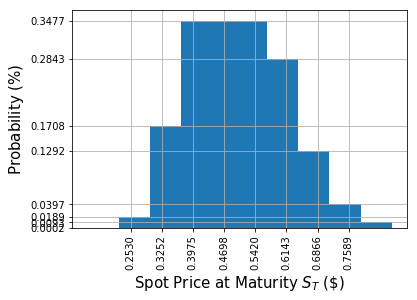

- probabilities: [0.01892728 0.17083438 0.34766127 0.28427483 0.12917195]
- target: 1    1.0
2    0.0
3    0.0
4    0.0
5    1.0
Name: target_frank, dtype: float64
- rounded probability: [0.0, 0.0, 0.0, 0.0, 0.0]
- accuracy:  1.1978773613157485e-05
- frank vs elizabeth corr: [[nan nan]
 [nan nan]]
Writing predictions to predictions.csv

Writing predictions to predictions_2019-04-26_20h28m32s.csv


In [12]:
# plot probability distribution
import time
x= uncertainty_model.values
print(x[:10])

y = uncertainty_model.probabilities 
print(y[:10])


plt.bar(x, y, width=0.2)
plt.xticks(x, size=10, rotation=90)
plt.yticks(y,size=10)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

# y_prediction = uncertainty_model.probabilities
# evaluate = model.evaluate(x_prediction,y_prediction)

probabilities = uncertainty_model.probabilities
print("- probabilities:", probabilities[1:6])

# We can see the probability does seem to be good at predicting the
# true target correctly.
print("- target:", prediction_data['target_frank'][1:6])
print("- rounded probability:", [np.round(p) for p in probabilities][1:6])

# But overall the accuracy is very low.
correct = [
np.round(x) == y
for (x, y) in zip(probabilities, prediction_data['target_frank'])]
print("- accuracy: ", sum(correct) / float(prediction_data.shape[0]))

tournament_corr = np.corrcoef(prediction_data['target_frank'],
                              prediction_data['target_elizabeth'])
print("- frank vs elizabeth corr:", tournament_corr)

results = y
results_df = pd.DataFrame(data={'probability_frank':results})

joined = pd.DataFrame(ids).join(results_df)
pd.DataFrame(joined[:5])


print("Writing predictions to predictions.csv")
path = 'predictions_{:}'.format(time.strftime("%Y-%m-%d_%Hh%Mm%Ss", time.gmtime())) + '.csv'
print()
print("Writing predictions to " + path.strip())
joined.to_csv(path,float_format='%.15f', index=False)


### Payoff Function

The payoff function equals zero as long as the spot price at maturity $S_T$ is less than the strike price $K$ and then increases linearly.
The implementation uses a comparator, that flips an ancilla qubit from $\big|0\rangle$ to $\big|1\rangle$ if $S_T \geq K$, and this ancilla is used to control the linear part of the payoff function.

The linear part itself is then approximated as follows.
We exploit the fact that $\sin^2(y + \pi/4) \approx y + 1/2$ for small $|y|$.
Thus, for a given approximation scaling factor $c_{approx} \in [0, 1]$ and $x \in [0, 1]$ we consider
$$ \sin^2( \pi/2 * c_{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_{approx} * ( x - 1/2 ) + 1/2 $$ for small $c_{approx}$.

We can easily construct an operator that acts as 
$$\big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right),$$
using controlled Y-rotations.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit, which corresponds to
$\sin^2(a*x+b)$.
Together with the approximation above, this allows to approximate the values of interest.
The smaller we choose $c_{approx}$, the better the approximation.
However, since we are then estimating a property scaled by $c_{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

For more details on the approximation, we refer to:
<a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>

In [25]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 0

# set the approximation scaling for the payoff function
c_approx = 1.0

# construct circuit factory for payoff function
european_call = EuropeanCallExpectedValue(
    uncertainty_model,
    strike_price=strike_price,
    c_approx=c_approx
)

[0.25296084 0.32523078 0.39750072 0.46977067 0.54204061 0.61431055
 0.68658049 0.75885044]
[0.25296084 0.32523078 0.39750072 0.46977067 0.54204061 0.61431055
 0.68658049 0.75885044]


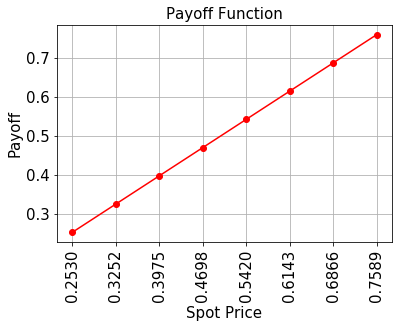

In [27]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
print(x)
y = np.maximum(0, x - strike_price)
print(y)

plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [28]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print('exact (normalized) expected value:\t%.4f' % exact_value)
print('exact (normalized) delta value:   \t%.4f' % exact_delta)

exact (normalized) expected value:	0.5052
exact (normalized) delta value:   	1.0000


### Evaluate Expected Payoff

In [29]:
# set number of evaluation qubits (samples)
m = 5

# construct amplitude estimation 
ae = AmplitudeEstimation(m, european_call)

In [30]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [31]:
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % result['estimation'])
print('Probability:    \t%.4f' % result['max_probability'])
result

Exact value:    	0.5052
Estimated value:	0.5381
Probability:    	0.7606


{'statevector': array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 'a_items': [(0.0, 0.0007891754737387211),
  (0.009607359798384776, 0.0016088659988895977),
  (0.03806023374435662, 0.0017057029844860612),
  (0.08426519384872735, 0.0018868518502480052),
  (0.14644660940672624, 0.0021909214679683093),
  (0.22221488349019888, 0.0026976004198234387),
  (0.3086582838174551, 0.0035827071113999683),
  (0.40245483899193585, 0.005290136550561941),
  (0.5000000000000001, 0.009217724908645843),
  (0.597545161008064, 0.021876605656612213),
  (0.6913417161825449, 0.12175418657369974),
  (0.777785116509801, 0.7606356513525248),
  (0.8535533905932737, 0.038538364314000345),
  (0.9157348061512728, 0.013152081078913025),
  (0.9619397662556434, 0.007307738776497633),
  (0.9903926402016151, 0.005345666247108277),
  (1.0, 0.002420019235721327)],
 'y_items': [(0, 0.0007891754737387211),
  (1, 0.0008044329994447941),
  (2, 0.000852851492243051),
  (3, 0.0009434259251240131),
  (4, 0.001095460

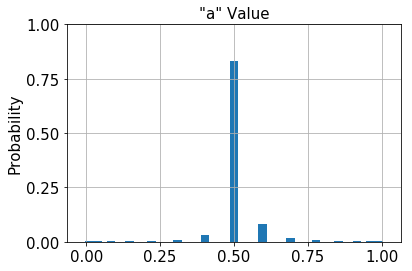

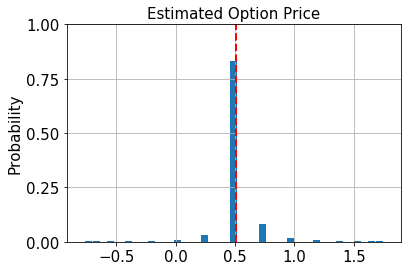

In [18]:
# plot estimated values for "a"
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price (after re-scaling and reversing the c_approx-transformation)
plt.bar(result['mapped_values'], result['probabilities'], width=1/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

### Evaluate Delta

The Delta is a bit simplier to evaluate than the expected payoff.
Similarly to the expected payoff, we use a comparator circuit and an ancilla qubit to identify the cases where $S_T \geq K$.
However, since we are only interested in the probability of this condition being true, we can directly use this ancilla qubit as the objective qubit in amplitude estimation without any futher approximation.

In [19]:
european_call_delta = EuropeanCallDelta(
    uncertainty_model,
    strike_price
)

In [20]:
# set number of evaluation qubits (=log(samples)
m = 5

# construct amplitude estimation 
ae_delta = AmplitudeEstimation(m, european_call_delta)

In [21]:
# result_delta = ae_delta.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result_delta = ae_delta.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [24]:
print('Exact delta:   \t%.4f' % exact_delta)
print('Esimated value:\t%.4f' % result_delta['estimation'])
print('Probability:   \t%.4f' % result_delta['max_probability'])

print(result_delta)

Exact delta:   	1.0000
Esimated value:	1.0000
Probability:   	1.0000
{'statevector': array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]), 'a_items': [(1.0, 1.0000000000002902)], 'y_items': [(16, 1.0000000000002902)], 'mapped_values': [1.0], 'values': [1.0], 'y_values': [16], 'probabilities': [1.0000000000002902], 'mapped_items': [(1.0, 1.0000000000002902)], 'estimation': 1.0, 'max_probability': 1.0000000000002902}


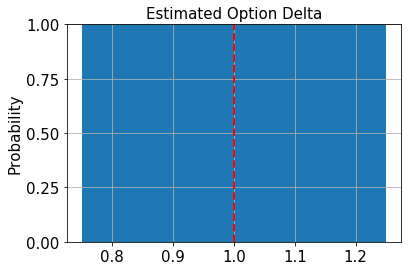

In [23]:
# plot estimated values for delta
plt.bar(result_delta['values'], result_delta['probabilities'], width=0.5/len(result_delta['probabilities']))
plt.plot([exact_delta, exact_delta], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Delta', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

In [ ]:
y_prediction = model.predict(x_prediction)
evaluate = model.evaluate(x_prediction,y_prediction)

probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])

# We can see the probability does seem to be good at predicting the
# true target correctly.
print("- target:", prediction_data['target_frank'][1:6])
print("- rounded probability:", [np.round(p) for p in probabilities][1:6])

# But overall the accuracy is very low.
correct = [
np.round(x) == y
for (x, y) in zip(probabilities, prediction_data['target_frank'])]
print("- accuracy: ", sum(correct) / float(prediction_data.shape[0]))

tournament_corr = np.corrcoef(prediction_data['target_frank'],
                              prediction_data['target_elizabeth'])
print("- frank vs elizabeth corr:", tournament_corr)